In [3]:
#!pip install seaborn
#!pip install nltk
#!pip install scikit-learn
#!pip install wordcloud
import sys 
import os
sys.path.append("../src/")
import data_loader
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import re
import string
import nltk 
from collections import Counter
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.util import ngrams
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [4]:
notebook_dir = os.getcwd()

figure_dir = os.path.join(notebook_dir, "..", "outputs", "figures")
figure_dir = os.path.normpath(figure_dir)
os.makedirs(figure_dir, exist_ok=True)

In [5]:
train_data, test_data = data_loader.load_data("train.csv", "test.csv")
train_data.head()

,review,sentiment
0,I caught this little gem totally by accident b...,positive
1,I can't believe that I let myself into this mo...,negative
2,*spoiler alert!* it just gets to me the nerve ...,negative
3,If there's one thing I've learnt from watching...,negative
4,"I remember when this was in theaters, reviews ...",negative


In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     40000 non-null  object
 1   sentiment  40000 non-null  object
dtypes: object(2)
memory usage: 625.1+ KB


In [7]:
train_data.describe(include="all")

,review,sentiment
count,40000,40000
unique,39728,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,20000


In [8]:
train_data.isnull().sum()

review       0
sentiment    0
dtype: int64

In [9]:
train_data['sentiment'].value_counts()

sentiment
positive    20000
negative    20000
Name: count, dtype: int64

In [10]:
train_data['review'].duplicated().sum()

np.int64(272)

In [11]:
train_data.drop_duplicates(subset='review',inplace=True)

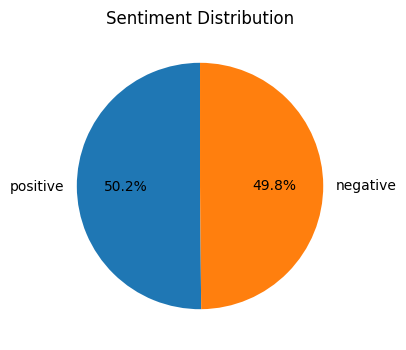

In [12]:
sentiment_distribution = (100 * train_data['sentiment'].value_counts() / train_data.shape[0]).round(2)
plt.figure(figsize=(4, 4))
plt.pie(sentiment_distribution, labels=sentiment_distribution.index, autopct='%1.1f%%', startangle=90)
plt.ylabel('')
plt.title('Sentiment Distribution')

plot_path = os.path.join(figure_dir, "sentiment_distribution.png")
plt.savefig(plot_path, dpi=300, bbox_inches='tight')

In [12]:
train_data['review_length'] = train_data['review'].str.len()
train_data.head()

,review,sentiment,review_length
0,I caught this little gem totally by accident b...,positive,892
1,I can't believe that I let myself into this mo...,negative,937
2,*spoiler alert!* it just gets to me the nerve ...,negative,468
3,If there's one thing I've learnt from watching...,negative,1960
4,"I remember when this was in theaters, reviews ...",negative,1015


In [13]:
def word_count(review):
    review_list = review.split()
    return len(review_list)

train_data['number_of_words'] = train_data['review'].apply(word_count)
train_data.head()

,review,sentiment,review_length,number_of_words
0,I caught this little gem totally by accident b...,positive,892,161
1,I can't believe that I let myself into this mo...,negative,937,170
2,*spoiler alert!* it just gets to me the nerve ...,negative,468,69
3,If there's one thing I've learnt from watching...,negative,1960,314
4,"I remember when this was in theaters, reviews ...",negative,1015,183


In [14]:
train_data['number_of_sentences'] = train_data['review'].apply(lambda x: len(sent_tokenize(x)))
train_data.head()

,review,sentiment,review_length,number_of_words,number_of_sentences
0,I caught this little gem totally by accident b...,positive,892,161,13
1,I can't believe that I let myself into this mo...,negative,937,170,5
2,*spoiler alert!* it just gets to me the nerve ...,negative,468,69,7
3,If there's one thing I've learnt from watching...,negative,1960,314,3
4,"I remember when this was in theaters, reviews ...",negative,1015,183,10


<Figure size 700x400 with 0 Axes>

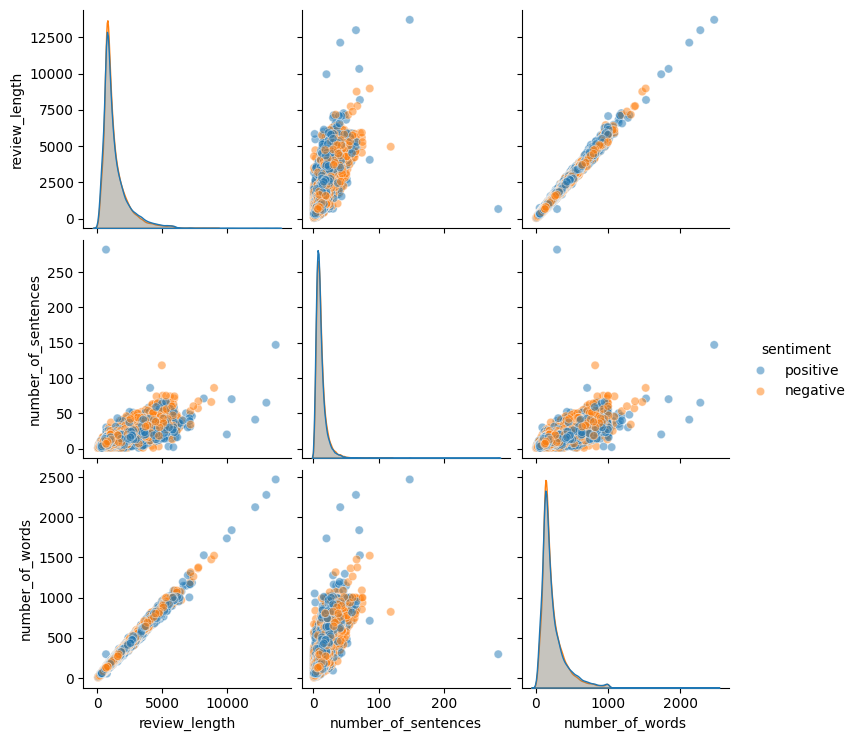

In [16]:
plt.figure(figsize=(7, 4))
sns.pairplot(train_data, vars=['review_length', 'number_of_sentences', 'number_of_words'], hue='sentiment', plot_kws={'alpha': 0.5})

plot_path = os.path.join(figure_dir, "review_metrics.png")
plt.savefig(plot_path, dpi=300, bbox_inches='tight')

In [12]:
def clean_review(text):
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    words = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

train_data['cleaned_review'] = train_data['review'].apply(clean_review)
train_data.head()

,review,sentiment,cleaned_review
0,I caught this little gem totally by accident b...,positive,caught little gem totally accident back reviva...
1,I can't believe that I let myself into this mo...,negative,cant believe let movie accomplish favor friend...
2,*spoiler alert!* it just gets to me the nerve ...,negative,spoiler alert gets nerve people remake use ter...
3,If there's one thing I've learnt from watching...,negative,theres one thing ive learnt watching george ro...
4,"I remember when this was in theaters, reviews ...",negative,remember theaters reviews said horrible well d...


In [18]:
def get_top_words(data, sentiment, n=20):
    reviews = train_data[train_data['sentiment'] == sentiment]['cleaned_review']
    all_words = ' '.join(reviews).split()
    word_counts = Counter(all_words)
    return dict(word_counts.most_common(n))

def generate_wordcloud(word_freq, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()
    plot_path = os.path.join(figure_dir, title)
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')

In [19]:
positive_words = get_top_words(train_data, 'positive', n=20)
positive_words

{'film': 31695,
 'movie': 28647,
 'one': 20557,
 'like': 13439,
 'good': 11443,
 'great': 10002,
 'story': 9830,
 'see': 9436,
 'time': 9385,
 'well': 8713,
 'really': 8526,
 'also': 8493,
 'would': 8227,
 'even': 7415,
 'much': 7207,
 'first': 7013,
 'films': 6754,
 'people': 6704,
 'best': 6656,
 'love': 6641}

In [20]:
negative_words = get_top_words(train_data, 'negative', n=20)
negative_words

{'movie': 37828,
 'film': 27851,
 'one': 19576,
 'like': 17291,
 'even': 11812,
 'bad': 11269,
 'good': 11248,
 'would': 10874,
 'really': 9758,
 'time': 9117,
 'see': 8408,
 'dont': 7957,
 'get': 7859,
 'much': 7757,
 'story': 7718,
 'could': 7170,
 'people': 7127,
 'make': 7107,
 'movies': 6668,
 'made': 6660}

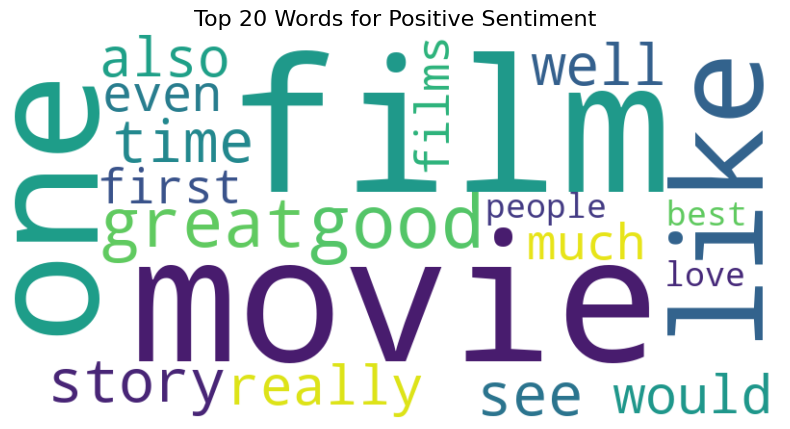

<Figure size 640x480 with 0 Axes>

In [21]:
generate_wordcloud(positive_words, 'Top 20 Words for Positive Sentiment')

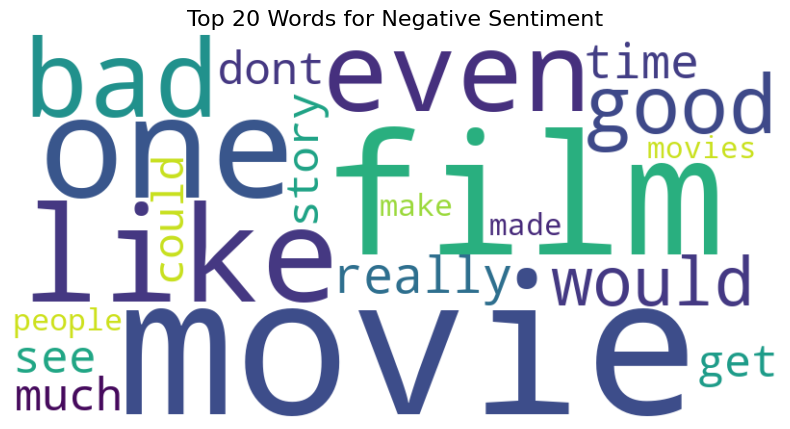

<Figure size 640x480 with 0 Axes>

In [22]:
generate_wordcloud(negative_words, 'Top 20 Words for Negative Sentiment')

In [13]:
train_data['review_tokens'] = train_data['cleaned_review'].apply(word_tokenize)
train_data['review_tokens'].head()

0    [caught, little, gem, totally, accident, back,...
1    [cant, believe, let, movie, accomplish, favor,...
2    [spoiler, alert, gets, nerve, people, remake, ...
3    [theres, one, thing, ive, learnt, watching, ge...
4    [remember, theaters, reviews, said, horrible, ...
Name: review_tokens, dtype: object

In [15]:
stemmer = PorterStemmer()
train_data['stemmed_tokens'] = train_data['review_tokens'].apply(lambda tokens: ' '.join([stemmer.stem(word) for word in tokens]))
train_data['stemmed_tokens'].head()

0    caught littl gem total accid back reviv theatr...
1    cant believ let movi accomplish favor friend a...
2    spoiler alert get nerv peopl remak use term lo...
3    there one thing ive learnt watch georg romero ...
4    rememb theater review said horribl well didnt ...
Name: stemmed_tokens, dtype: object

In [14]:
lemmatizer = WordNetLemmatizer()
train_data['lemmatized_tokens'] = train_data['review_tokens'].apply(lambda tokens: ' '.join([lemmatizer.lemmatize(word) for word in tokens]))
train_data['lemmatized_tokens'].head()

0    caught little gem totally accident back reviva...
1    cant believe let movie accomplish favor friend...
2    spoiler alert get nerve people remake use term...
3    there one thing ive learnt watching george rom...
4    remember theater review said horrible well did...
Name: lemmatized_tokens, dtype: object

In [26]:
X_train_lemm, X_test_lemm, y_train, y_test = train_test_split(train_data['lemmatized_tokens'], train_data['sentiment'], test_size=0.2, random_state=42)
X_train_stemm, X_test_stemm, y_train, y_test = train_test_split(train_data['stemmed_tokens'], train_data['sentiment'], test_size=0.2, random_state=42)

In [27]:
vectorizer_lemm = CountVectorizer()
vectorized_lemm_reviews_train = vectorizer_lemm.fit_transform(X_train_lemm)
vectorized_lemm_reviews_test = vectorizer_lemm.transform(X_test_lemm)

vectorizer_stemm = CountVectorizer()
vectorized_stemm_reviews_train = vectorizer_stemm.fit_transform(X_train_stemm)
vectorized_stemm_reviews_test = vectorizer_stemm.transform(X_test_stemm)

In [28]:
tfidf_vectorizer_lemm = TfidfVectorizer()
X_train_lemm_tfidf = tfidf_vectorizer_lemm.fit_transform(X_train_lemm)
X_test_lemm_tfidf = tfidf_vectorizer_lemm.transform(X_test_lemm)

tfidf_vectorizer_stemm = TfidfVectorizer()
X_train_stemm_tfidf = tfidf_vectorizer_stemm.fit_transform(X_train_stemm)
X_test_stemm_tfidf = tfidf_vectorizer_stemm.transform(X_test_stemm)

In [32]:
lr_results = {}

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(vectorized_lemm_reviews_train, y_train)
lr_results["LogisticRegression on CountVectorizer_Lemmatized"] = accuracy_score(y_test, log_reg.predict(vectorized_lemm_reviews_test))

log_reg.fit(vectorized_stemm_reviews_train, y_train)
lr_results["LogisticRegression on CountVectorizer_Stemmed"] = accuracy_score(y_test, log_reg.predict(vectorized_stemm_reviews_test))

log_reg.fit(X_train_lemm_tfidf, y_train)
lr_results["LogisticRegression on TFIDF_Lemmatized"] = accuracy_score(y_test, log_reg.predict(X_test_lemm_tfidf))

log_reg.fit(X_train_stemm_tfidf, y_train)
lr_results["LogisticRegression on TFIDF_Stemmed"] = accuracy_score(y_test, log_reg.predict(X_test_stemm_tfidf))

In [30]:
svm_results = {}

svm_model = SVC()
svm_model.fit(vectorized_lemm_reviews_train, y_train)
svm_results["SVM on CountVectorizer_Lemmatized"] = accuracy_score(y_test, svm_model.predict(vectorized_lemm_reviews_test))

svm_model.fit(vectorized_stemm_reviews_train, y_train)
svm_results["SVM on CountVectorizer_Stemmed"] = accuracy_score(y_test, svm_model.predict(vectorized_stemm_reviews_test))

svm_model.fit(X_train_lemm_tfidf, y_train)
svm_results["SVM on TFIDF_Lemmatized"] = accuracy_score(y_test, svm_model.predict(X_test_lemm_tfidf))

svm_model.fit(X_train_stemm_tfidf, y_train)
svm_results["SVM on TFIDF_Stemmed"] = accuracy_score(y_test, svm_model.predict(X_test_stemm_tfidf))

In [31]:
rf_results = {}

rf_model = RandomForestClassifier()
rf_model.fit(vectorized_lemm_reviews_train, y_train)
rf_results["RandomForest on CountVectorizer_Lemmatized"] = accuracy_score(y_test, rf_model.predict(vectorized_lemm_reviews_test))

rf_model.fit(vectorized_stemm_reviews_train, y_train)
rf_results["RandomForest on CountVectorizer_Stemmed"] = accuracy_score(y_test, rf_model.predict(vectorized_stemm_reviews_test))

rf_model.fit(X_train_lemm_tfidf, y_train)
rf_results["RandomForest on TFIDF_Lemmatized"] = accuracy_score(y_test, rf_model.predict(X_test_lemm_tfidf))

rf_model.fit(X_train_stemm_tfidf, y_train)
rf_results["RandomForest on TFIDF_Stemmed"] = accuracy_score(y_test, rf_model.predict(X_test_stemm_tfidf))

In [34]:
all_results = {**lr_results, **svm_results, **rf_results}

for combination, accuracy in all_results.items():
    print(f"{combination}: {accuracy:.4f}")

LogisticRegression on CountVectorizer_Lemmatized: 0.8814
LogisticRegression on CountVectorizer_Stemmed: 0.8808
LogisticRegression on TFIDF_Lemmatized: 0.8890
LogisticRegression on TFIDF_Stemmed: 0.8880
SVM on CountVectorizer_Lemmatized: 0.8709
SVM on CountVectorizer_Stemmed: 0.8718
SVM on TFIDF_Lemmatized: 0.8952
SVM on TFIDF_Stemmed: 0.8937
RandomForest on CountVectorizer_Lemmatized: 0.8507
RandomForest on CountVectorizer_Stemmed: 0.8446
RandomForest on TFIDF_Lemmatized: 0.8480
RandomForest on TFIDF_Stemmed: 0.8419


In [15]:
    def train_with_hyperparameter_tuning(model, param_grid, df, text_col, label_col, cv=5):
        """
        Trains and tunes a model using TF-IDF vectorization and cross-validation.
        """
        # Apply TF-IDF Vectorization
        vectorizer = TfidfVectorizer()
        X = vectorizer.fit_transform(df[text_col])
        y = df[label_col]
    
        # Train-test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
        # Hyperparameter tuning with GridSearchCV
        grid_search = GridSearchCV(model, param_grid, cv=cv, scoring='accuracy', n_jobs=-1, verbose=1)
        grid_search.fit(X_train, y_train)
    
        # Get the best model and parameters
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
    
        print("Best Parameters:", best_params)
    
        # Evaluate on the test set
        y_pred = best_model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
    
        print("Test Accuracy:", acc)

In [16]:
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf']
}

train_with_hyperparameter_tuning(SVC(), param_grid, train_data, text_col='lemmatized_tokens', label_col='sentiment')

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Parameters: {'C': 10, 'kernel': 'rbf'}
Test Accuracy: 0.896551724137931
